## This notebook contains data standardization and various machine learning models, including a GridSearch to programatically try differnent hyperparameters

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import skew, skewtest
import seaborn as sns
import matplotlib.pyplot as plt

#Need to specify fips as str to prevent losing leading 0s
df = pd.read_csv("./processeddata/census_health_citycounty_income_final.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

%matplotlib inline

In [20]:
# Dropping Nas, would be better to figure out how to find missing income data by zipcode or impute somehow
# perhaps by using closest location where income was found for a zipcode
df = df.dropna(subset=["Median_Income_2017"])

In [21]:
df.Median_Income_2017.isnull().sum()

0

(array([1453., 3646.,  610.,   46.,   82.,   83.,   20.,    0.,    0.,
          33.]),
 array([ 25451.,  41188.,  56925.,  72662.,  88399., 104136., 119873.,
        135610., 151347., 167084., 182821.]),
 <a list of 10 Patch objects>)

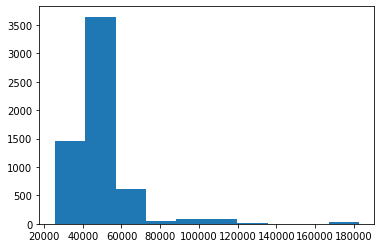

In [22]:
#Need to correct skep of median income 
plt.hist(df["Median_Income_2017"])

In [24]:
print(skewtest(df["Median_Income_2017"]))

SkewtestResult(statistic=60.30140615869754, pvalue=0.0)


In [25]:
log_transform_array = np.log(df["Median_Income_2017"])
log10_transform_array = np.log10(df["Median_Income_2017"])
root_transform_array = np.sqrt(df["Median_Income_2017"])

In [26]:
print(skewtest(log_transform_array))
print(skewtest(log10_transform_array))
print(skewtest(root_transform_array))

SkewtestResult(statistic=39.404116260414966, pvalue=0.0)
SkewtestResult(statistic=39.40411626041489, pvalue=0.0)
SkewtestResult(statistic=50.89387423202458, pvalue=0.0)


(array([ 145.,  481., 2236., 2140.,  631.,  101.,  103.,  103.,    0.,
          33.]),
 array([10.14451031, 10.34168556, 10.53886081, 10.73603606, 10.93321131,
        11.13038656, 11.32756181, 11.52473706, 11.72191231, 11.91908756,
        12.11626281]),
 <a list of 10 Patch objects>)

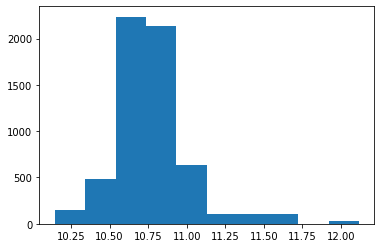

In [5]:
# Log transform will normalize the data, one outlier at e^12
plt.hist(np.log(df["Median_Income_2017"]))

### Breakpoint for later

In [ ]:
health.shape, income.shape

In [ ]:
df = pd.merge(income, health, how="inner",on="fips")

In [ ]:
#We lose a large portion of the fips codes, as they do not have income data
# There is still a lot of data wrapped up in these 41 rows, as they are aggregations to the county level
# Getting more precise income data would allow us to keep more rows

df.shape

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(), annot = True, ax= ax, cmap="coolwarm")
### looking at correlation between variables and per capita income

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV

In [ ]:
df.columns

In [ ]:
X = df[['COPD', 'CHOLSCREEN', 'KIDNEY', 'BINGE', 'CHECKUP',
       'PHLTH', 'OBESITY', 'ARTHRITIS', 'CASTHMA', 'DENTAL', 'SLEEP', 'CANCER',
       'LPA', 'BPHIGH', 'DIABETES', 'STROKE', 'BPMED', 'CSMOKING', 'MHLTH',
       'CHD']] ## features for modeling
# X = df[["MHLTH", "SLEEP", "BINGE", "CHECKUP", "BPHIGH", "LPA"]]
y = df['Per capitaincome'] ## target for modeling

In [ ]:
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,y) #train test split

In [ ]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test) # scale the features with scaler fit on training data

In [ ]:
baseline_prediction_val = np.mean(y_train)
baseline_predictions = np.array([baseline_prediction_val for i in range(len(y_test))])

In [ ]:
baseline_mse = mean_squared_error(y_test, baseline_predictions) ** .5

In [ ]:
baseline_mse

## Simple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

In [ ]:
### originally used select K best, but model performed best using all features

In [ ]:
lr = LinearRegression()
model = lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
mean_squared_error(y_test, preds) ** .5

In [ ]:
np.std(model.coef_), np.mean(model.coef_) # used these values to create a standardized importance for the features below

In [ ]:
coefs = pd.DataFrame({"features":X_train.columns, "coef": model.coef_})

In [ ]:
coefs["importance"] = [(x-110.101)/1758.232 for x in coefs.coef]

In [ ]:
coefs.sort_values("importance", ascending=False).set_index("features", drop = True) # dataframe of feature importance

## Random Forest With Gridsearch

In [ ]:
rf = RandomForestRegressor()
params = {"n_estimators":[3,7,10,12,15],
         "max_depth":[None,7,5,3],
         "min_samples_split":[2,3,4],
         "min_samples_leaf":[1,2],
         "n_jobs":[4]}

In [ ]:
gs = GridSearchCV(estimator=rf, param_grid=params)

In [ ]:
gs.fit(X_train_scaled,y_train)

In [ ]:
gs.best_params_

In [ ]:
preds = gs.predict(X_test_scaled)

In [ ]:
mean_squared_error(y_test, preds) ** .5

## Lasso

In [ ]:
las = LassoCV(n_jobs=4, max_iter=15000)
las.fit(X_train_scaled, y_train)
preds = las.predict(X_test_scaled)
mean_squared_error(y_test, preds)** .5